Tests to implement:

1. KDD/GDD biases
2. LH/SH biases
3. Do these biases scale with ag production
4. Do these biases change over the growing season
5. Do historical cmip6 temperature biases predict future changes

In [2]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import scipy
import statsmodels.api as sm
import cartopy
import cartopy.util
import cartopy.crs as ccrs
import glob
import sys, os
import pickle, gzip
import datetime

In [3]:
run ../util/setupConsole_su

In [4]:
dirCmip6 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/CMIP6'
dirERA5 = '/home/edcoffel/drive/MAX-Filer/Research/Climate-02/Data-02-edcoffel-F20/ERA5'
dirDeepak = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate/deepak'
dirAgData = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'
dirProj = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/research/2020-ag-cmip6'
dirSacks = '/home/edcoffel/drive/MAX-Filer/Research/Climate-01/Personal-F20/edcoffel-F20/data/projects/ag-land-climate'


In [5]:
# files = glob.glob('%s/cmip6_output/*.nc'%dirProj)
# for f in files:
#     os.rename(f,'%s.nc'%f[0:-4]) 

In [6]:
with gzip.open('%s/gdd-kdd-lat-era5.dat'%dirAgData, 'rb') as f:
    era5_lat = pickle.load(f)
with gzip.open('%s/gdd-kdd-lon-era5.dat'%dirAgData, 'rb') as f:
    era5_lon = pickle.load(f)

In [7]:
cmip6_models = ['access-cm2', 'access-esm1-5', 'awi-cm-1-1-mr', 'bcc-csm2-mr', 'bcc-esm1', 'canesm5', 'ec-earth3', \
                'gfdl-cm4', 'gfdl-esm4', 'giss-e2-1-g', 'kace-1-0-g', 'fgoals-g3', 'inm-cm5-0', 'ipsl-cm6a-lr', 'miroc6', \
                'mpi-esm1-2-hr', 'mpi-esm1-2-lr', 'mri-esm2-0', 'noresm2-lm', 'noresm2-mm', 'sam0-unicon']

In [14]:
region = 'global'
crop = 'Maize'
if region == 'global':
    latRange = [-90, 90]
    lonRange = [0, 360]
elif region == 'us':
    latRange = [20, 57]
    lonRange = [220, 300]
elif region == 'china':
    latRange = [25, 45]
    lonRange = [105, 123]
elif region == 'eu':
    latRange = [38, 56]
    lonRange = [-5, 40]

latIndRange_era5 = np.where((era5_lat >= latRange[0]) & (era5_lat <= latRange[1]))[0]
lonIndRange_era5 = np.where((era5_lon >= lonRange[0]) & (era5_lon <= lonRange[1]))[0]

regridMesh_current = xr.Dataset({'lat': (['lat'], np.arange(latRange[0], latRange[1], 1.5)),
                            'lon': (['lon'], np.arange(lonRange[0], lonRange[1], 1.5)),})

regridMesh_global = xr.Dataset({'lat': (['lat'], np.arange(-90, 90, 1.5)),
                                'lon': (['lon'], np.arange(0, 360, 1.5)),})


if region == 'global':
    regridMesh = regridMesh_global
else:
    regridMesh = regridMesh_current

    
rcp = 'historical'
model = 'access-esm1-5'
members = np.array([x.split('/')[-2] for x in glob.glob("%s/%s/*/"%(dirCmip6, model))])

In [15]:
sacksMaizeNc = xr.open_dataset('%s/sacks/%s.crop.calendar.fill.nc'%(dirSacks, crop))
sacksStart = sacksMaizeNc['plant'].values
sacksStart = np.roll(sacksStart, -int(sacksStart.shape[1]/2), axis=1)
sacksStart[sacksStart < 0] = np.nan
sacksEnd = sacksMaizeNc['harvest'].values
sacksEnd = np.roll(sacksEnd, -int(sacksEnd.shape[1]/2), axis=1)
sacksEnd[sacksEnd < 0] = np.nan

In [16]:
with open('cropped_area/crop_land_regrid.dat', 'rb') as f:
    crop_all_area_regrid = pickle.load(f)
with open('cropped_area/pasture_land_regrid.dat', 'rb') as f:
    pasture_area_regrid = pickle.load(f)

In [17]:
cmip6_tasmax_grow_max = xr.Dataset()

for m, member in enumerate(members):

    if not os.path.isfile('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_%s_regrid.nc'%(crop, region, model, member)):
        print('skipping tasmax max %s, %s'%(model, member))
        
        continue
    

    ds_global_txx = xr.open_dataset('cmip6_output/growing_season/cmip6_%s_tasmax_grow_max_%s_%s_%s_regrid.nc'%(crop, region, model, member))
    
    if m == 0:
        cmip6_tasmax_grow_max = ds_global_txx
    else:
        cmip6_tasmax_grow_max = xr.concat([cmip6_tasmax_grow_max, ds_global_txx], dim='member')

In [19]:
# load pre-calculated bias by year

# monthly_groups = cmip6_tasmax_monthly_max.groupby('time.month').groups


yearly_tasmax_grow_max_bias = np.full([len(members), cmip6_tasmax_grow_max.time.values.shape[0], \
                                  cmip6_tasmax_grow_max.lat.values.shape[0], \
                                  cmip6_tasmax_grow_max.lon.values.shape[0]], np.nan)


for m, member in enumerate(members):
    print('loading yearly bias for %s, %s'%(member, model))

    with open('cmip6_output/bias/yearly-cmip6-era5-tasmax-grow-max-bias-%s-%s-%s.dat'%(region, model, member), 'rb') as f:
        yearly_tasmax_grow_max_bias[m, :, :, :] = pickle.load(f)


loading yearly bias for r10i1p1f1, access-esm1-5
loading yearly bias for r11i1p1f1, access-esm1-5
loading yearly bias for r12i1p1f1, access-esm1-5
loading yearly bias for r13i1p1f1, access-esm1-5
loading yearly bias for r14i1p1f1, access-esm1-5
loading yearly bias for r15i1p1f1, access-esm1-5
loading yearly bias for r16i1p1f1, access-esm1-5
loading yearly bias for r17i1p1f1, access-esm1-5
loading yearly bias for r18i1p1f1, access-esm1-5
loading yearly bias for r19i1p1f1, access-esm1-5
loading yearly bias for r1i1p1f1, access-esm1-5
loading yearly bias for r20i1p1f1, access-esm1-5
loading yearly bias for r21i1p1f1, access-esm1-5
loading yearly bias for r22i1p1f1, access-esm1-5
loading yearly bias for r23i1p1f1, access-esm1-5
loading yearly bias for r24i1p1f1, access-esm1-5
loading yearly bias for r25i1p1f1, access-esm1-5
loading yearly bias for r26i1p1f1, access-esm1-5
loading yearly bias for r27i1p1f1, access-esm1-5
loading yearly bias for r28i1p1f1, access-esm1-5
loading yearly bias f

In [12]:
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from shapely import geometry
from collections import namedtuple
from shapely.geometry.polygon import LinearRing

def plot_polygon(ax, sub_region):
    """
    https://groups.google.com/forum/#!topic/scitools-iris/LxR0EbQolyE
    Note:
    ----
    order is important:
        lower-left, upper-left, upper-right, lower-right
        2 -- 3
        |    |
        1 -- 4
    """
    # ax = fig.axes[0]
    lats = [sub_region.latmin, sub_region.latmin, sub_region.latmax, sub_region.latmax]
    lons = [sub_region.lonmin, sub_region.lonmax, sub_region.lonmax, sub_region.lonmin]
    ring = LinearRing(list(zip(lons, lats)))
    ax.add_geometries([ring], ccrs.PlateCarree(), facecolor='none', edgecolor='black', lw=2)
    return ax


Region = namedtuple('Region',field_names=['region_name','lonmin','lonmax','latmin','latmax'])

region_us = Region(
    region_name="Midwest",
    lonmin = -115,
    lonmax = -80,
    latmin = 30,
    latmax = 55,
)

region_europe = Region(
    region_name="Europe",
    lonmin = 0,
    lonmax = 60,
    latmin = 35,
    latmax = 55,
)

region_india = Region(
    region_name="India",
    lonmin = 68,
    lonmax = 90,
    latmin = 5,
    latmax = 35,
)

region_china = Region(
    region_name="China",
    lonmin = 100,
    lonmax = 130,
    latmin = 20,
    latmax = 48,
)

region_sahel = Region(
    region_name="Sahel",
    lonmin = -15,
    lonmax = 50,
    latmin = 2,
    latmax = 17,
)

region_sa = Region(
    region_name="SA",
    lonmin = -68,
    lonmax = -50,
    latmin = -48,
    latmax = -25,
)

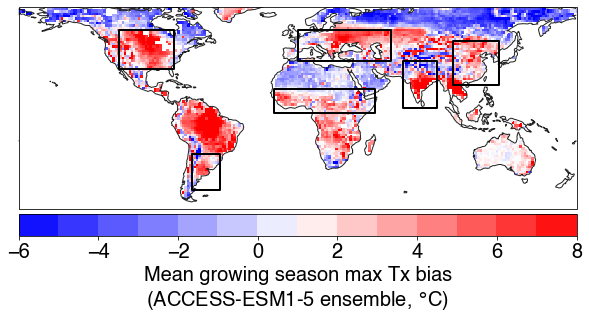

In [45]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=ccrs.PlateCarree())


ax.set_extent([-180, -180, 70, -60])
v1 = -6
v2 = 8.01
vstep = 1
vlabelstep = 2

midnorm = MidpointNormalize(vmin=v1, vcenter=(v1+v2)/2, vmax=v2)
cmap = plt.cm.get_cmap('bwr')

c = plt.pcolormesh(regridMesh['lon'], regridMesh['lat'], \
                 np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias, axis=0), axis=0), \
                 cmap=cmap, norm=midnorm)

if region == 'global':
    ax.add_feature(cartopy.feature.COASTLINE.with_scale('110m'), edgecolor='#222222')
else:
    ax.add_feature(cartopy.feature.STATES.with_scale('10m'), edgecolor='#222222')

    
plot_polygon(ax, region_us)
plot_polygon(ax, region_europe)
plot_polygon(ax, region_india)
plot_polygon(ax, region_china)
plot_polygon(ax, region_sahel)
plot_polygon(ax, region_sa)
    
scmap = plt.cm.ScalarMappable(cmap=cmap, norm=midnorm)
scmap.set_array([])
cb = plt.colorbar(scmap, ticks=np.arange(v1, v2, vlabelstep), 
             boundaries=np.arange(v1, v2, vstep), orientation='horizontal',
             pad=0.01, aspect=25, shrink=1)
cb.ax.tick_params(labelsize=20)
cb.set_label('Mean growing season max Tx bias\n(ACCESS-ESM1-5 ensemble, $\degree$C)', fontsize=20)

plt.savefig('tx-bias-access-esm1-5-ensemble-map.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)


In [27]:
with open('cropped_area/crop_land_regrid.dat', 'rb') as f:
    crop_all_area_regrid = pickle.load(f)
with open('cropped_area/pasture_land_regrid.dat', 'rb') as f:
    pasture_area_regrid = pickle.load(f)

In [28]:
crop_all_area_regrid_1d = np.reshape(crop_all_area_regrid, [crop_all_area_regrid.size,1])

In [29]:
%%time
if not os.path.isfile('irrigation_data_regrid_120_240.dat'):
    faoIrrigationFile = '%s/fao-irrigation/gmia_v5_aei_pct.asc'%dirAgData
    irrigationData = np.genfromtxt(faoIrrigationFile, skip_header=6)
    irrigationLat = np.linspace(90,-90,irrigationData.shape[0])
    irrigationLon = np.linspace(-180,180,irrigationData.shape[1])
    irrigationLon[irrigationLon<0] += 360

    regridder = xe.Regridder(xr.DataArray(data=irrigationData, dims=['lat', 'lon'], coords={'lat':irrigationLat, 'lon':irrigationLon}), regridMesh, 'bilinear')
    irrigation_data_regrid = regridder(irrigationData)

    with open('irrigation_data_regrid_120_240.dat', 'wb') as f:
        pickle.dump(irrigation_data_regrid, f)
else:
    with open('irrigation_data_regrid_120_240.dat', 'rb') as f:
        irrigation_data_regrid = pickle.load(f)
    irrigation_data_regrid[irrigation_data_regrid == 0] = np.nan
    irrigation_data_regrid /= 100
    irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.shape[0]*irrigation_data_regrid.shape[1],1])

CPU times: user 0 ns, sys: 2 ms, total: 2 ms
Wall time: 76.2 ms


In [30]:
irrigation_data_regrid_1d = irrigation_data_regrid.reshape([irrigation_data_regrid.size,1])

In [31]:
yearly_tasmax_grow_max_bias_1d = np.nanmean(np.nanmean(yearly_tasmax_grow_max_bias, axis=0), axis=0)
yearly_tasmax_grow_max_bias_1d = yearly_tasmax_grow_max_bias_1d.reshape([yearly_tasmax_grow_max_bias_1d.size])

yearly_tasmax_grow_max_bias_2d = np.nanmean(yearly_tasmax_grow_max_bias, axis=1)
yearly_tasmax_grow_max_bias_2d = yearly_tasmax_grow_max_bias_2d.reshape([yearly_tasmax_grow_max_bias_2d.shape[0], yearly_tasmax_grow_max_bias_2d.shape[1]*yearly_tasmax_grow_max_bias_2d.shape[2]])


In [33]:
yearly_tasmax_grow_max_bias_2d.shape

(40, 28800)

In [37]:
bins = [0,.01,.05,.1,.2,.3, .4, .5, .6, .7, .8]
binned_tx_bias = []
binned_tx_bias_per_member = []


for b,bcur in enumerate(bins):
    if b == len(bins)-1:
        ind = np.where((crop_all_area_regrid_1d >= bcur))[0]
#         ind = np.where((crop4_area_regrid_1d >= bcur))[0]
    else:
        ind = np.where((crop_all_area_regrid_1d >= bcur) & (crop_all_area_regrid_1d < bins[b+1]))[0]
#         ind = np.where((crop4_area_regrid_1d >= bcur) & (crop4_area_regrid_1d < bins[b+1]))[0]

    binned_tx_bias.append(np.nanmean(yearly_tasmax_grow_max_bias_1d[ind]))
    
    for m in range(yearly_tasmax_grow_max_bias_2d.shape[0]):
        if b == 0:
            binned_tx_bias_per_member.append([])
            
        binned_tx_bias_per_member[m].append(np.nanmean(yearly_tasmax_grow_max_bias_2d[m,ind]))


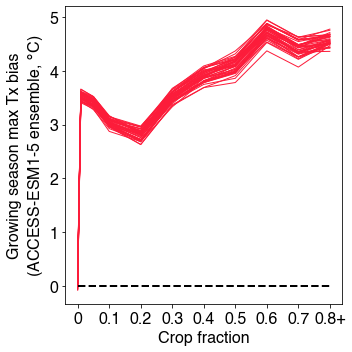

In [44]:
fig = plt.figure(figsize=(5,5))
# ax[0].plot(bins, binned_tx_bias, label='Growing season max Tx', lw=5, c='#fc1c3a')
plt.plot(bins,np.array(binned_tx_bias_per_member).T, lw=1, c='#fc1c3a')
plt.plot([0, 0.8], [0, 0], '--k', lw=2)
plt.xlabel('Crop fraction', fontsize=16)
plt.xticks(np.arange(0, .81, .1), fontsize=16)
plt.yticks(fontsize=16)
plt.gca().set_xticklabels(['0', '0.1', '0.2', '0.3', '0.4', '0.5', '0.6', '0.7', '0.8+'], fontsize=16)
plt.ylabel('Growing season max Tx bias\n(ACCESS-ESM1-5 ensemble, $\degree$C)', fontsize=16)
# ax[0].legend(prop={'size': 14}, frameon=False)

plt.tight_layout()

plt.savefig('binned-tx-bias-access-esm1-5-ensemble.png', format='png', dpi=500, bbox_inches = 'tight', pad_inches = 0.02)